In [1]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers

#### Examples: run one cell

In [2]:
### Example: random vs uniform states ###

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = [rand_state(n) for i=1:n_samples*2]
states2 = [uniform_state(n) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [10]:
### Example: high- vs low- entanglement states ###

function classify_state(n, label; threshold=0.6, max_iter=1000)
    state = rand_state(n)
    iter = 0
    if label == 1
        while von_neumann_entropy(state, 1) < threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    else
        while von_neumann_entropy(state, 1) > threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") :
    return state
end

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 10
states1 = [classify_state(n, 1) for i=1:n_samples*2]
states2 = [classify_state(n, -1) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

#### Model parameters

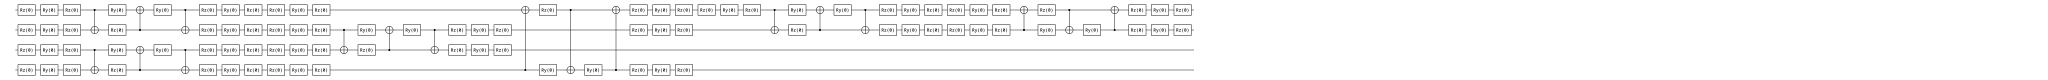

In [19]:
iters = 300 # number of iterations
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
sig = true # use the sigmoid activation function
ansatz = conv_SU4 # conv_Ry, conv_Ry2, conv_SU4

circ = build_QCNN(n, ansatz=ansatz)

p = GenericParams(n=n, circ=circ)
# p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

YaoPlots.plot(circ)

#### Run

In [20]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, p, iters, optim, sig; output=false)

Initial: loss = 1.8306771649758606,tr_acc = 0.4, te_acc = 0.4
Final: loss = 0.0018007969305753602,tr_acc = 1.0, te_acc = 0.7


([0.6491857401592701, 5.563997672050248, 3.234227090367225, 5.3501681759108415, 0.5480731505268248, 0.8618753213812519, 2.874851176159108, 3.716533631712669, 1.9650675620353595, 4.047285062562498  …  4.423893139229376, 0.005303177806763217, 2.9170912142955063, 4.0535532599709425, 4.312700752641554, 4.078561863930019, 2.3903619498415254, 1.2745672854136978, 5.120730580898835, 0.5386988150770002], [1.8306771649758606, 1.2376471411033245, 1.002874747027256, 0.659569372093136, 0.3828007080160367, 0.2733298686749701, 0.19869484921312117, 0.17553893126769668, 0.16541497257906398, 0.1376743128382647  …  0.0018169822086014538, 0.0018151235913314635, 0.001813280359795918, 0.0018114523744338015, 0.001809639496599449, 0.0018078415885522143, 0.0018060585134469815, 0.0018042901353249052, 0.0018025363191048933, 0.0018007969305753602], [0.4, 0.55, 0.65, 0.8, 0.9, 0.9, 0.9, 1.0, 0.95, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.4, 0.45, 0.45, 0.55, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65 

#### Plot

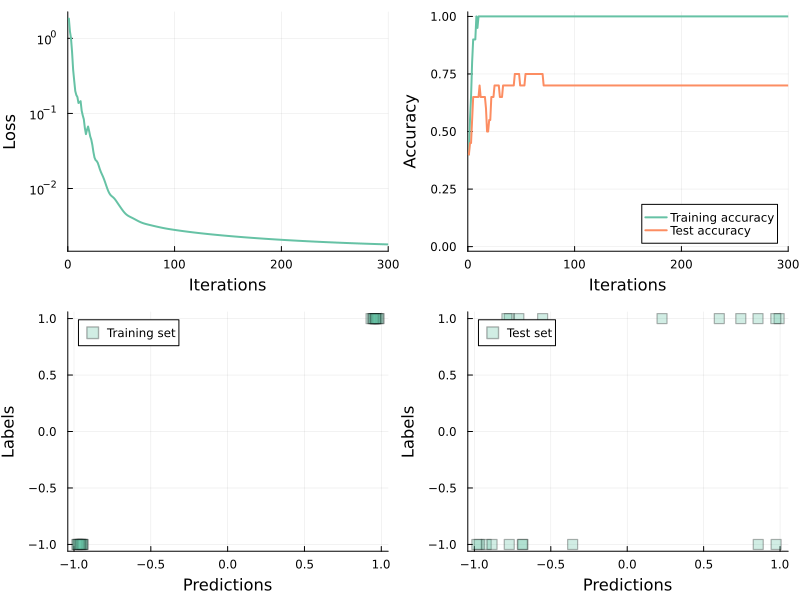

In [22]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
Plots.plot!(loss_track, yaxis=:log, label=false)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy")
Plots.plot!(te_track, label="Test accuracy")

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set")

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set")

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))